In [29]:
#Library for edit dataset
import pandas as pd
import numpy as np
import datetime as dp

#Library for visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import folium 
from folium.plugins import StripePattern
import branca.colormap
from collections import defaultdict
from folium.plugins import HeatMap

#Calculate distance on latitude and longitude
from math import radians, cos, sin, asin, sqrt

#Library to find correlation in categorical data
from pandas import factorize

# Modeling
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.utils import resample
import warnings
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')


# **Introduction**

**This project covers Customer Segmentation Using KMeans Clustering based on RFM (Recency, Frequency, Monetary)Analytics**

## **Background**

E-commerce is a business model that allows companies or individuals to buy or sell goods via the internet. E-commerce customers have unimaginable variety personalities, a potential market is usually not characterized singularly nor easily. It becomes important to know your target customer base in order to make sure your communications are both effective (attractive, action-promoting) and appropriate (non-offensive, timely, and relevant).[1] RFM analysis is a customer behavior segmentation technique. Based on customers' historical transactions, RFM analysis focuses on 3 main aspects of customers' transactions: recency, frequency and purchase amount. Understanding these behaviors will allow businesses to cluster different customers into groups. [2]



# **Data Understanding**

## **Dataset Publik E-Commerce Brasil oleh Olist**

The dataset has information of 100k orders from 2016 to 2018 made in several markets in Brazil. This is real commercial data, it has been anonymized.
This dataset is generously provided by Olist, the largest department store on the Brazilian market. Olist connects small businesses from all over Brazil to the channel without any hassle and with one contract. The merchant can sell their products through the Olist Store and have them shipped directly to the customer using the Olist logistics partner. Once the customer purchases the product from the Olist Store, the seller will be notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey via email where he or she can provide a note for the purchase experience and some comments.

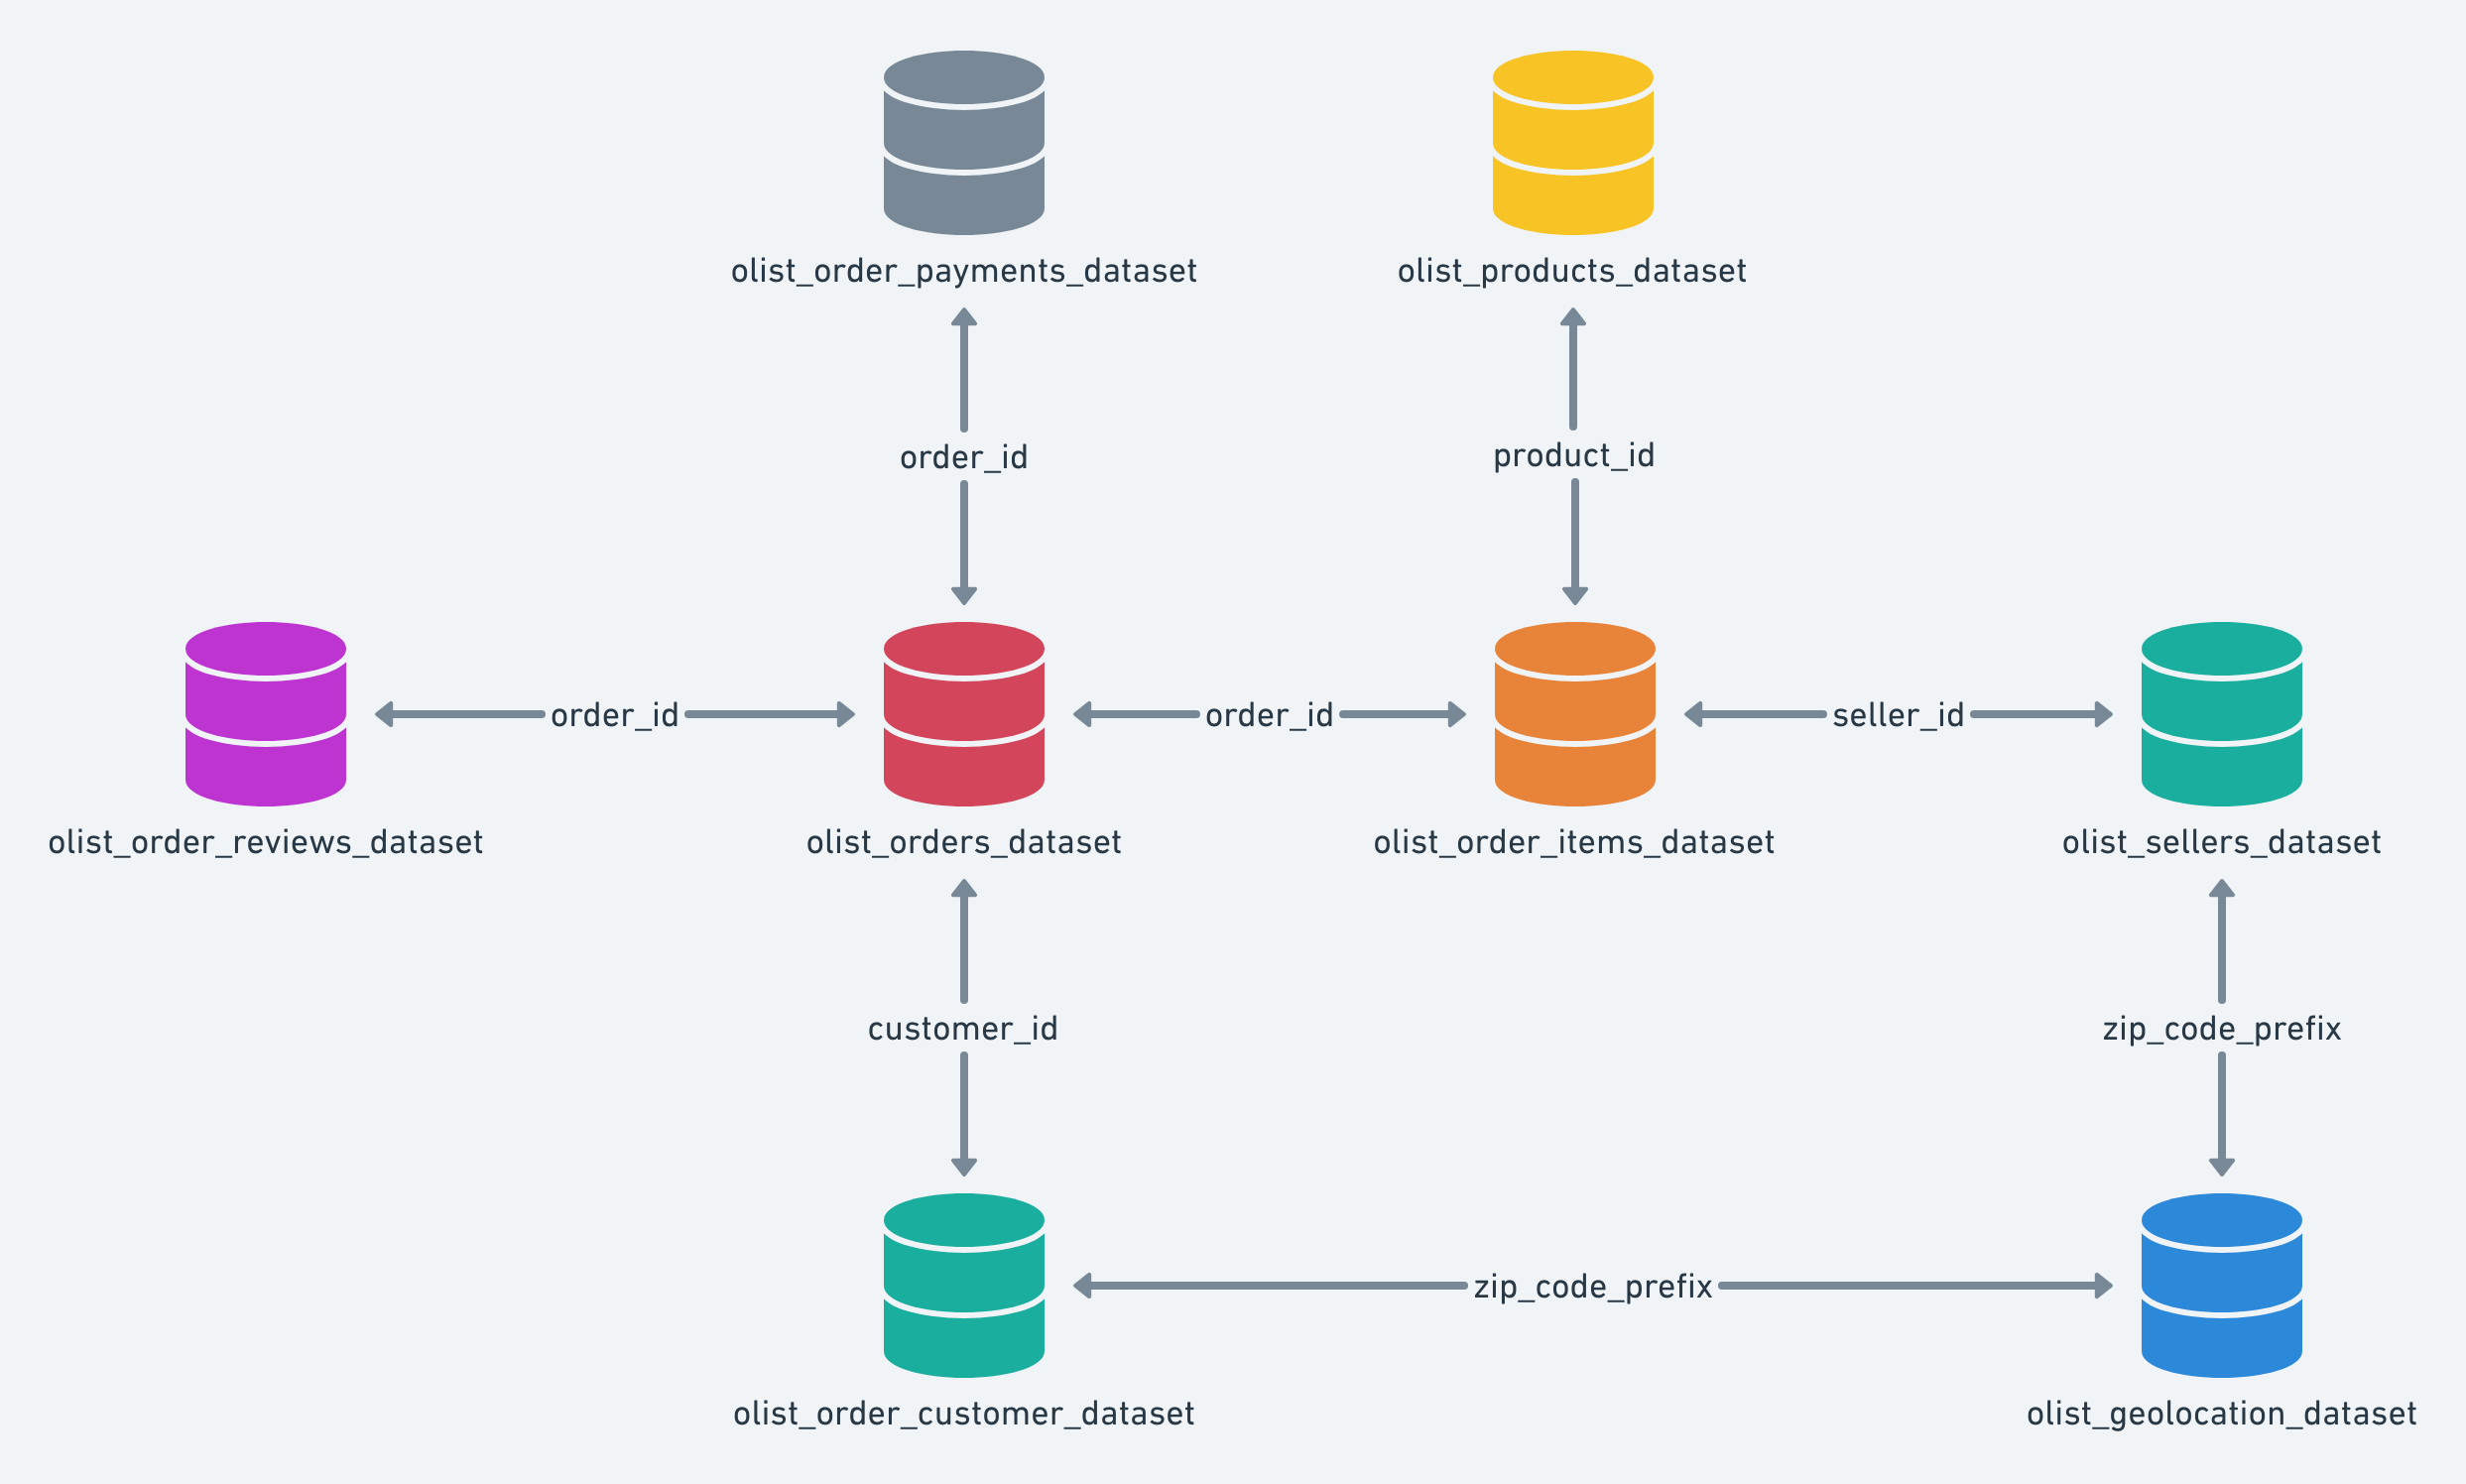

| Columns Name | Data Type, Length | Description | Present |
| -- | -- | -- | -- |
| customer_id | object | Key to the orders dataset. Each order has a unique customer_id.| Unique customer id to merge with orders dataset |
| customer_unique_id | object | unique identifier of a customer.| represent customer unique id
| customer_zip_code_prefix | int64 | first five digits of customer zip code| represent first five zip code of geolocation customer
| customer_city  |  object |customer city name| a customer city name in brazzil
| customer_state |  object |customer state| represent 2 letters of name customer sate
| geolocation_zip_code_prefix | int64 |first 5 digits of zip code| represent first five zip code of geolocation city and state
| geolocation_lat | float64 |Geolocation latitude| represent of the angular distance of a place north or south of the earth's equator, or of a celestial object north or south of the celestial equator, expressed in degrees.
| geolocation_lng | float64 |Geolocation longitude| the angular distance of a place east or west of the meridian at Greenwich, England, or west of the standard meridian of a celestial object, expressed in degrees.
| geolocation_city |  object |city name| represent of geolocation city name
| geolocation_state |  object |state| represent 2 letter of state where the geolocation is 
| order_id  |  object |order unique identifier| An unique id where every transaction have order id
| order_item_id | int64 |sequential number identifying number of items included in the same order.| A serial number for an unique identifier assigned  sequentially to an item, to uniquely identify it
| product_id  |  object |product unique identifier| A serial number for a unique identifier assigned  to an product, to uniquely identify it
| seller_id | object  |seller unique identifier| A serial number for a unique identifier assigned  to an seller, to uniquely identify it
| shipping_limit_date| object  |Shows the seller shipping limit date for handling the order over to the logistic partner.| the estimated delivery date is when a customer can reasonably expect the order to arrive.
| price | float64 |item price| the retail price of each item of consumer goods.
| freight_value | float64 |item freight value item (if an order has more than one item the freight value is splitted between)|  a price at which a certain cargo is delivered from one point to another
| payment_sequential | int64 |a customer may pay an order with more than one payment method. If he does so, a sequence will be| a sequential pay structure, principal payments are typically allocated to the securities in order of seniority.
| payment_type |  object |method of payment chosen by the customer.| A various of type payment for customer to pay a transaction
| payment_installments | int64 |number of installments chosen by the customer.| Instalment payments refer to a customer paying a bill in small portions throughout a fixed period of time
| payment_value  | float64 | transaction value.| A total of amount money customer need to pay to succesfull transaction

In [30]:
# Change the product name to english
products = pd.read_csv("olist_products_dataset.csv")
prod_cat_name_tr = pd.read_csv("product_category_name_translation.csv")
products = products.merge(prod_cat_name_tr, on='product_category_name', how='left')
products.drop ('product_category_name', axis=1, inplace=True)

In [31]:
#load all the tables
o_items = pd.read_csv("olist_order_items_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
o_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
geoloc = pd.read_csv("olist_geolocation_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
o_payments = pd.read_csv("olist_order_payments_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")

In [32]:
# Join the needed table
df = orders.merge(o_items, on='order_id', how='left')
df = df.merge(o_payments, on='order_id', how='outer', validate='m:m')
df = df.merge(products, on='product_id', how='outer')
df = df.merge(customers, on='customer_id', how='outer')
df = df.merge(sellers, on='seller_id', how='outer')

In [33]:
# remove columns yang tidak butuh
df = df.drop(axis=1,
columns=['product_name_lenght',
'product_description_lenght',
'product_photos_qty',
'product_weight_g',
'product_length_cm',
'product_height_cm',
'product_width_cm',
'order_delivered_carrier_date',
'order_delivered_customer_date',
'order_estimated_delivery_date'
,'shipping_limit_date','order_approved_at'])

In [34]:
# Change to Datetime
df['order_purchase_date']=pd.to_datetime(df['order_purchase_timestamp'])

In [35]:
df['order_purchase_date'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_purchase_date'] = df['order_purchase_date'].dt.strftime('%Y-%m-%d-%H')
df['order_purchase_date'] = pd.to_datetime(df['order_purchase_date'])

In [36]:
df['year'] = df['order_purchase_date'].dt.year
df['month'] = df['order_purchase_date'].dt.strftime('%b')
df['day'] = df['order_purchase_date'].dt.day
df['hour'] = df['order_purchase_date'].dt.hour

# **Preprocessing**

### **Drop Duplicated Data**

In [37]:
df.drop_duplicates(subset=['order_id'], inplace = True)

### **Drop Misspelling and Anomali Data**


**This dataset has some misspeling in seller_city column, there are 04482255, vendas@creditparts.com.br, rio de janeiro / rio de janeiro, sao paulo / sao paulo, rio de janeiro \\rio de janeiro, ribeirao preto / sao paulo, sp, carapicuiba / sao paulo, mogi das cruzes / sp, sp / sp, auriflama/sp, pinhais/pr, cariacica / es, jacarei / sao paulo, sao sebastiao da grama/sp, maua/sao paulo,  and lages - sc.**

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 118433
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  object        
 4   order_item_id                  98666 non-null  float64       
 5   product_id                     98666 non-null  object        
 6   seller_id                      98666 non-null  object        
 7   price                          98666 non-null  float64       
 8   freight_value                  98666 non-null  float64       
 9   payment_sequential             99440 non-null  float64       
 10  payment_type                   99440 non-null  object        
 11  payment_instal

In [39]:
df = df[(df['payment_type'] != 'not_defined') | (df['seller_city'] != '04482255') | (df['seller_city'] != 'vendas@creditparts.com.br') |
        (df['seller_city'] != 'rio de janeiro / rio de janeiro') | (df['seller_city'] != 'sao paulo / sao paulo') | (df['seller_city'] != 'rio de janeiro \\rio de janeiro') 
        | (df['seller_city'] != 'ribeirao preto / sao paulo' ) | (df['seller_city'] != 'sp') | (df['seller_city'] != 'carapicuiba / sao paulo') | (df['seller_city'] != 'mogi das cruzes / sp')
        | (df['seller_city'] != 'sp / sp') | (df['seller_city'] != 'auriflama/sp') | (df['seller_city'] != 'pinhais/pr') | (df['seller_city'] != 'cariacica / es') | (df['seller_city'] != 'jacarei / sao paulo')
        | (df['seller_city'] != 'sao sebastiao da grama/sp') | (df['seller_city'] != 'maua/sao paulo') | (df['seller_city'] != ' ') | (df['seller_city'] != 'lages - sc') 
        | (df['year'] != 2016) | (df['order_purchase_timestamp'] != '2018-09-03 09:06:57')]

### **Drop mising value**

In [40]:
df.dropna(axis=0,inplace=True,subset=['product_id', 'seller_id', 'payment_sequential','payment_type', 'payment_installments', 'payment_value'])

In [41]:
df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_item_id                       0
product_id                          0
seller_id                           0
price                               0
freight_value                       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
product_category_name_english    1433
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
seller_zip_code_prefix              0
seller_city                         0
seller_state                        0
order_purchase_date                 0
year                                0
month                               0
day                                 0
hour                                0
dtype: int64

In [42]:
df['product_category_name_english'].fillna('Missing', inplace = True)

In [43]:
df.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_item_id                    0
product_id                       0
seller_id                        0
price                            0
freight_value                    0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
product_category_name_english    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
seller_zip_code_prefix           0
seller_city                      0
seller_state                     0
order_purchase_date              0
year                             0
month                            0
day                              0
hour                             0
dtype: int64

In [44]:
#Combine dataframe with geolocation coordinates.

df.rename(columns={'customer_zip_code_prefix': 'zip_code_prefix'}, inplace = True)

In [45]:
df_geo = df[['zip_code_prefix', 'seller_id', 'customer_id', 'order_id', 'customer_state']]
geoloc.rename(columns={'geolocation_zip_code_prefix': 'zip_code_prefix'}, inplace = True)
df_geo = df_geo.merge(geoloc, on = 'zip_code_prefix', how = 'left')

In [28]:
#Remove coordinate point that not in Brazil.
#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
df_geo = df_geo[df_geo.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
df_geo = df_geo[df_geo.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
df_geo = df_geo[df_geo.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
df_geo = df_geo[df_geo.geolocation_lng <=  -34.79314722]


### **Making Data Frame for RFM Analytics & Models**

**At our system each order is assigned to a unique customerid. This means that the same customer will get different ids for different orders. The purpose of having a customerunique_id on the dataset is to allow you to identify customers that made repurchases at the store**

### Recency

How often buyers make purchases based on the time gap between purchases

In [46]:
recency = df[['customer_unique_id', 'order_purchase_date']].copy()

In [47]:
#calculating recency value
recency = recency.groupby('customer_unique_id')['order_purchase_date'].max().reset_index()
recency.columns = ['customer_unique_id', 'last_purchase_timestamp']

recency['purchase_int'] = (recency['last_purchase_timestamp'].max() - recency['last_purchase_timestamp']).dt.days
recency.drop(columns='last_purchase_timestamp', inplace=True)

In [48]:
#finding best cluster spliter based on percentile
recency_cluster=list(recency['purchase_int'].quantile([0,0.25,0.50,0.75,1]))

In [49]:
#segment each value to cluster
recency_lst = recency['purchase_int']
recency_cluster = []

for i in recency_lst:
    if i < 165:
        cluster = 0
        recency_cluster.append(cluster)
    elif i < 270:
        cluster = 1
        recency_cluster.append(cluster)
    elif i < 399:
        cluster = 2
        recency_cluster.append(cluster)
    else:
        cluster = 3
        recency_cluster.append(cluster)


In [50]:
#adding cluster column
recency['recency_cluster'] = recency_cluster
recency

,customer_unique_id,purchase_int,recency_cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,115,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,0
2,0000f46a3911fa3c0805444483337064,541,3
3,0000f6ccb0745a6a4b88665a16c9f078,325,2
4,0004aac84e0df4da2b147fca70cf8255,292,2
...,...,...,...
95414,fffcf5a5ff07b0908bd4e2dbc735a684,451,3
95415,fffea47cd6d3cc0a88bd621562a9d061,266,1
95416,ffff371b4d645b6ecea244b27531430a,572,3
95417,ffff5962728ec6157033ef9805bacc48,123,0


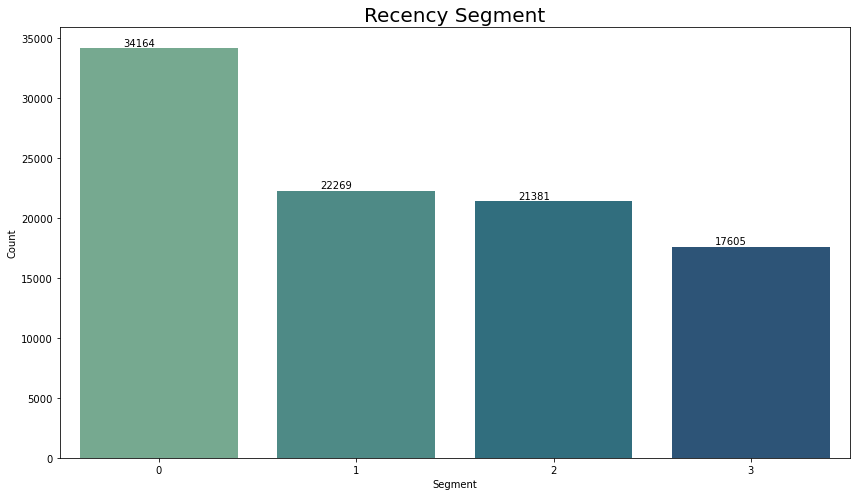

In [51]:
plt.figure(figsize=(12, 7))
recency_cat = recency['recency_cluster'].value_counts()
pal = sns.color_palette('crest', len(recency_cat))
graph =sns.barplot(x=recency_cat.index, y=recency_cat.values, palette=pal) 
for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')     
plt.title('Recency Segment', size=20)
plt.ylabel('Count')
plt.xlabel('Segment')
plt.tight_layout()
plt.show()

### Frequency


In [52]:
frequency =pd.DataFrame(df.groupby('customer_unique_id')['order_id'].count().reset_index())
frequency


,customer_unique_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
95414,fffcf5a5ff07b0908bd4e2dbc735a684,1
95415,fffea47cd6d3cc0a88bd621562a9d061,1
95416,ffff371b4d645b6ecea244b27531430a,1
95417,ffff5962728ec6157033ef9805bacc48,1


Text(0.5, 1.0, 'Distribution of the number of orders per customer')

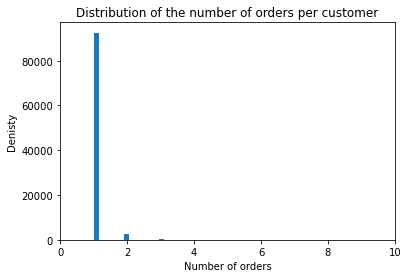

In [53]:
#look for distribution
frequency['order_id'].plot.hist(bins=100)
plt.xlim(0,10)
plt.xlabel('Number of orders')
plt.ylabel('Denisty')
plt.title('Distribution of the number of orders per customer')

In [54]:
#find best k using kmeans
inertia = {}

for k in range(1,10):
    km = KMeans(n_clusters=k)
    km = km.fit(frequency[['order_id']])
    inertia[k] = km.inertia_

Text(0, 0.5, 'Inertia')

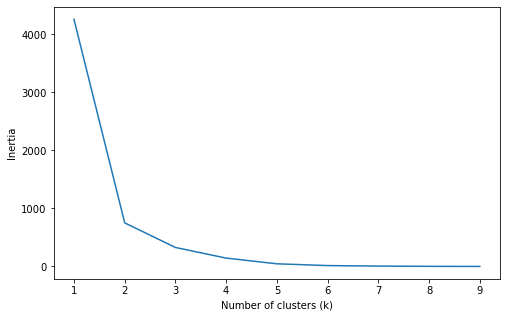

In [55]:
plt.figure(figsize=(8,5))
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')

In [56]:
#applying kmeans
km = KMeans(n_clusters=4, random_state=42)
km.fit(frequency[['order_id']])
frequency['cluster'] = km.labels_

In [57]:
#checking cluster distribution
frequency['cluster'].value_counts()


0    92506
2     2673
1      230
3       10
Name: cluster, dtype: int64

In [58]:
frequency.groupby('cluster')['order_id'].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,92506.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
2,2673.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
1,230.0,3.204348,0.491836,3.0,3.0,3.0,3.0,5.0
3,10.0,7.600000,3.098387,6.0,6.0,6.5,7.0,16.0


In [59]:
#reassign cluster grouping for better intepretation
frequency_cluster = frequency.groupby('cluster')['order_id'].mean().reset_index()
frequency_cluster = frequency_cluster.sort_values(by='order_id').reset_index(drop=True)
frequency_cluster['index'] = np.arange(0,4)
frequency_cluster.set_index('cluster', inplace=True)
cluster_dict = frequency_cluster['index'].to_dict()
frequency['cluster'].replace(cluster_dict, inplace=True)

In [60]:
frequency.groupby('cluster')['order_id'].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,92506.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,2673.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
2,230.0,3.204348,0.491836,3.0,3.0,3.0,3.0,5.0
3,10.0,7.600000,3.098387,6.0,6.0,6.5,7.0,16.0


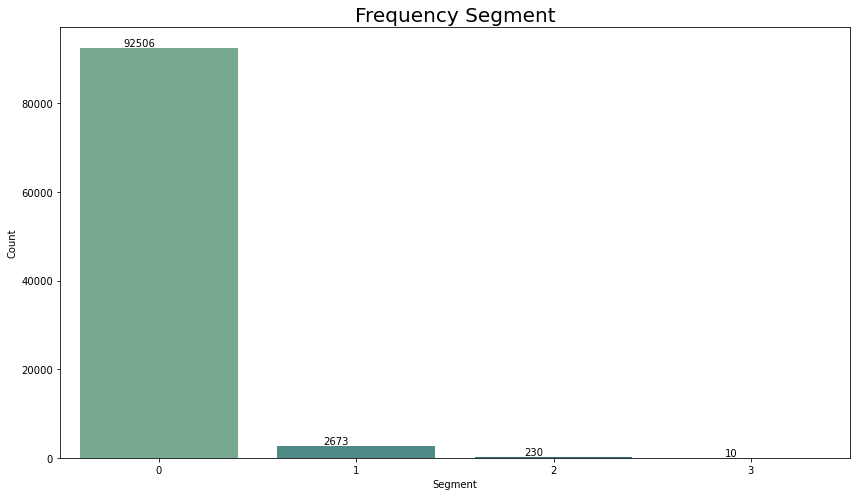

In [61]:
plt.figure(figsize=(12, 7))
frequency_cat = frequency['cluster'].value_counts()
pal = sns.color_palette('crest', len(frequency_cat))
graph =sns.barplot(x=frequency_cat.index, y=frequency_cat.values, palette=pal) 
for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')     
plt.title('Frequency Segment', size=20)
plt.ylabel('Count')
plt.xlabel('Segment')
plt.tight_layout()
plt.show()

### Monetary

In [62]:
monetary =pd.DataFrame(df.groupby('customer_unique_id')['payment_value'].sum().reset_index())
monetary


,customer_unique_id,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89
...,...,...
95414,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42
95415,fffea47cd6d3cc0a88bd621562a9d061,84.58
95416,ffff371b4d645b6ecea244b27531430a,112.46
95417,ffff5962728ec6157033ef9805bacc48,133.69


In [63]:
#checking splitter based on percentile
monetary_cluster=list(monetary['payment_value'].quantile([0,0.25,0.50,0.75,1]))

In [64]:
monetary_cluster

[0.01, 61.44, 106.26, 180.79500000000002, 13664.08]

In [65]:
#dividing value to a cluster
monetary_lst = monetary['payment_value']
monetary_cluster = []

for i in monetary_lst:
    if i < 61.44:
        cluster = 0
        monetary_cluster.append(cluster)
    elif i < 106.26:
        cluster = 1
        monetary_cluster.append(cluster)
    elif i < 183.79:
        cluster = 2
        monetary_cluster.append(cluster)
    else:
        cluster = 3
        monetary_cluster.append(cluster)


In [66]:
monetary['monetary_cluster'] = monetary_cluster

In [67]:
monetary

,customer_unique_id,payment_value,monetary_cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,0
2,0000f46a3911fa3c0805444483337064,86.22,1
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,0
4,0004aac84e0df4da2b147fca70cf8255,196.89,3
...,...,...,...
95414,fffcf5a5ff07b0908bd4e2dbc735a684,2067.42,3
95415,fffea47cd6d3cc0a88bd621562a9d061,84.58,1
95416,ffff371b4d645b6ecea244b27531430a,112.46,2
95417,ffff5962728ec6157033ef9805bacc48,133.69,2


In [68]:
monetary.groupby('monetary_cluster')['payment_value'].describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
monetary_cluster,,,,,,,,
0,23850.0,41.355281,12.576693,0.01,32.770,42.505,51.6800,61.43
1,23859.0,81.902485,13.072061,61.44,70.245,81.000,93.1000,106.25
2,24374.0,140.353519,21.875330,106.26,120.730,138.445,158.7075,183.78
3,23336.0,395.256476,362.505264,183.79,217.540,278.920,415.5250,13664.08


In [69]:
#checking cluster distribution
monetary['monetary_cluster'].value_counts()

2    24374
1    23859
0    23850
3    23336
Name: monetary_cluster, dtype: int64

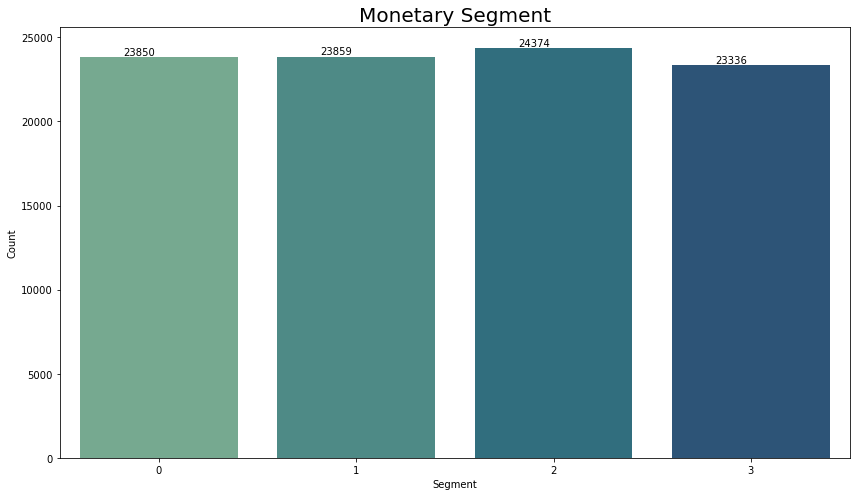

In [70]:
plt.figure(figsize=(12, 7))
monetary_cat = monetary['monetary_cluster'].value_counts()
pal = sns.color_palette('crest', len(monetary_cat))
graph =sns.barplot(x=monetary_cat.index, y=monetary_cat.values, palette=pal) 
for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')     
plt.title('Monetary Segment', size=20)
plt.ylabel('Count')
plt.xlabel('Segment')
plt.tight_layout()
plt.show()

In [71]:
# Merging each column
overall = recency.merge(frequency, on='customer_unique_id')
overall = overall.merge(monetary, on='customer_unique_id')

# Rename columns for better intepretation
overall.rename(columns={'cluster':'frequency_cluster', 'purchase_int':'recency', 'num_transaction':'frequency','payment_value':'monetary','order_id':'frequency'}, inplace=True)

# Adding overall column by sum all cluster
overall['overall_score'] = overall['recency_cluster']+overall['frequency_cluster']+overall['monetary_cluster']

overall

,customer_unique_id,recency,recency_cluster,frequency,frequency_cluster,monetary,monetary_cluster,overall_score
0,0000366f3b9a7992bf8c76cfdf3221e2,115,0,1,0,141.90,2,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,0,1,0,27.19,0,0
2,0000f46a3911fa3c0805444483337064,541,3,1,0,86.22,1,4
3,0000f6ccb0745a6a4b88665a16c9f078,325,2,1,0,43.62,0,2
4,0004aac84e0df4da2b147fca70cf8255,292,2,1,0,196.89,3,5
...,...,...,...,...,...,...,...,...
95414,fffcf5a5ff07b0908bd4e2dbc735a684,451,3,1,0,2067.42,3,6
95415,fffea47cd6d3cc0a88bd621562a9d061,266,1,1,0,84.58,1,2
95416,ffff371b4d645b6ecea244b27531430a,572,3,1,0,112.46,2,5
95417,ffff5962728ec6157033ef9805bacc48,123,0,1,0,133.69,2,2


## **Methodology (Machine Learning)**

#### From here, we can group several overall_score into segment. Here decided that we will have 4 main segment. Loyal, Valuable, Regular, Passive. We will group 0-1 score as passive, 2-4 as Regular, 5-7 as Valuable, 8-9 as Loyal.

**Without modelling, we can get 4 clusters, there are passive, regular, valuable, and loyal. Passive is when frequency, frequency, and monetary values are the lowest. Regular is when transaction value is incresing but still low and monetary value is the second lowest after passive, recency value is still the lowest. Valuable is when monetary value is the second highest, frequency value is high, and transaction value is in the middle of all values. Loyal is frequency, frequency, and monetary values are the highest.**

In [72]:
#assign customer segmentation based on overall score
segment_lst = overall['overall_score']
segment_cluster = []

for i in segment_lst:
    if i <= 1:
        cluster = 'passive'
        segment_cluster.append(cluster)
    elif i <= 4:
        cluster = 'regular'
        segment_cluster.append(cluster)
    elif i <= 7:
        cluster = 'valuable'
        segment_cluster.append(cluster)
    else:
        cluster = 'loyal'
        segment_cluster.append(cluster)

In [73]:
overall['customer_segment'] = segment_cluster

In [74]:
overall['customer_segment'].value_counts()

regular     58725
passive     22145
valuable    14531
loyal          18
Name: customer_segment, dtype: int64

In [75]:
overall

,customer_unique_id,recency,recency_cluster,frequency,frequency_cluster,monetary,monetary_cluster,overall_score,customer_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,115,0,1,0,141.90,2,2,regular
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,0,1,0,27.19,0,0,passive
2,0000f46a3911fa3c0805444483337064,541,3,1,0,86.22,1,4,regular
3,0000f6ccb0745a6a4b88665a16c9f078,325,2,1,0,43.62,0,2,regular
4,0004aac84e0df4da2b147fca70cf8255,292,2,1,0,196.89,3,5,valuable
...,...,...,...,...,...,...,...,...,...
95414,fffcf5a5ff07b0908bd4e2dbc735a684,451,3,1,0,2067.42,3,6,valuable
95415,fffea47cd6d3cc0a88bd621562a9d061,266,1,1,0,84.58,1,2,regular
95416,ffff371b4d645b6ecea244b27531430a,572,3,1,0,112.46,2,5,valuable
95417,ffff5962728ec6157033ef9805bacc48,123,0,1,0,133.69,2,2,regular


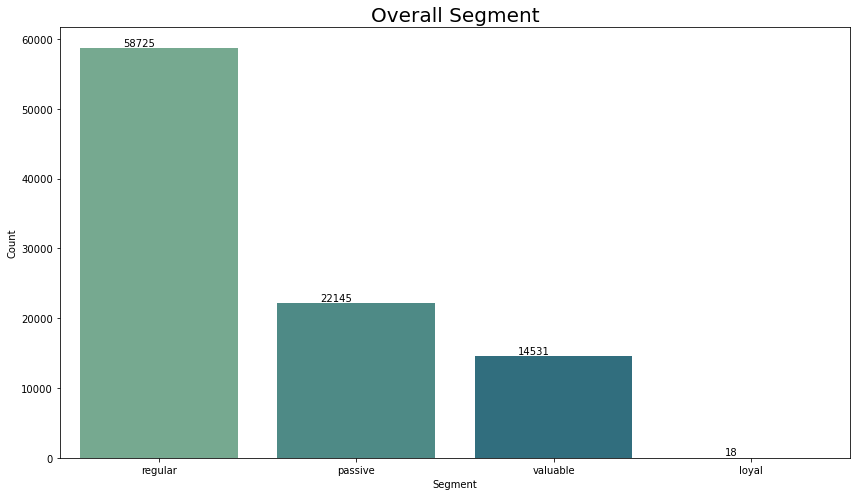

In [76]:
plt.figure(figsize=(12, 7))
overall_cat = overall['customer_segment'].value_counts()
pal = sns.color_palette('crest', len(overall_cat))
graph =sns.barplot(x=overall_cat.index, y=overall_cat.values, palette=pal) 
for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')     
plt.title('Overall Segment', size=20)
plt.ylabel('Count')
plt.xlabel('Segment')
plt.tight_layout()
plt.show()

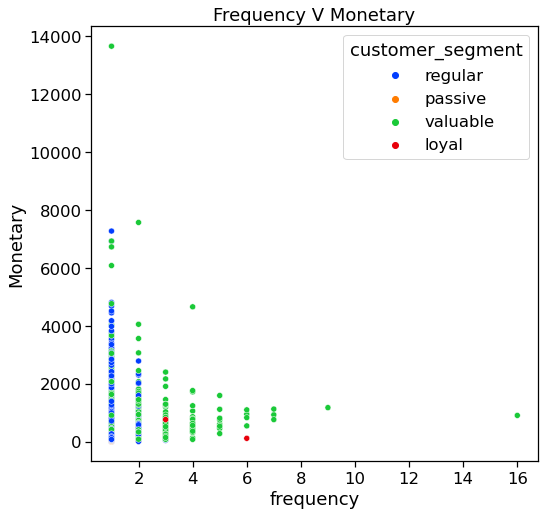

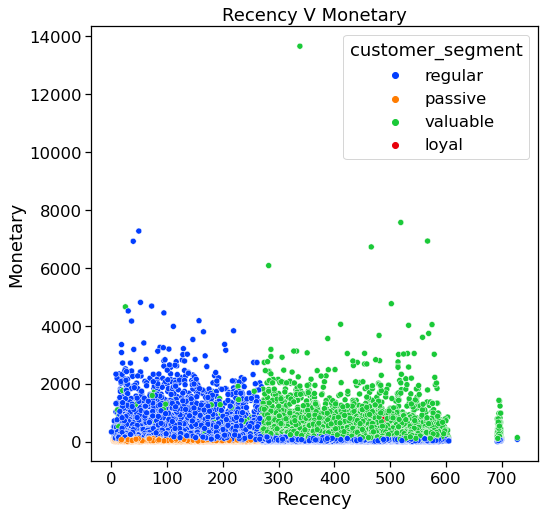

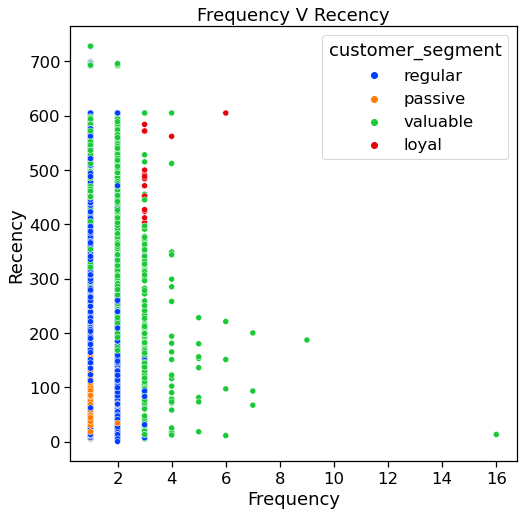

In [77]:
# Frequency V Monetary
plt.figure(figsize = (8, 8) )
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'frequency', 
    y = 'monetary', 
    hue = 'customer_segment',
    data = overall,
    palette='bright')
plt.title('Frequency V Monetary')
plt.ylabel('Monetary')
plt.xlabel('frequency')
plt.show()

# Monetary V Recency
plt.figure(figsize = (8, 8) )
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'recency', 
    y = 'monetary', 
    hue = 'customer_segment',
    data = overall,
    palette='bright')
plt.title('Recency V Monetary')
plt.ylabel('Monetary')
plt.xlabel('Recency')
plt.show()

# Frequency V Recency
plt.figure(figsize = (8, 8) )
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'frequency', 
    y = 'recency', 
    hue = 'customer_segment',
    data = overall,
    palette='bright')
plt.title('Frequency V Recency')
plt.ylabel('Recency')
plt.xlabel('Frequency')
plt.show()

## Jelaskan per cluster atau breakdown

## Using kuantitive Models KMeans(Sillhoutte)

**Using k-means, we can get 6 clusters, there are passive, regular, occation, valuable, loyal, and best. Passive is when frequency, frequency, and monetary values are the lowest. Regular is when transaction value is incresing but still low and monetary value is in the range low - medium. Occation is when monetary value is the second lowest after passive, recency value is the lowest, but transaction value is the highest. Valuable is when values of monetary and transaction is in the middle of all values. Loyal is when monetary value is the second highest, frequency value is high, and transaction value is in the middle of all values. Best is frequency, frequency, and monetary values are the highest.**

In [78]:
scaled_features = overall[['recency','frequency','monetary']].copy()

In [79]:
# Scaling our features
col_names = ['monetary', 'recency','frequency']
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [80]:
scaled_features[col_names] = features
scaled_features

,recency,frequency,monetary
0,-0.833414,-0.161046,-0.094902
1,-0.813826,-0.161046,-0.602808
2,1.948149,-0.161046,-0.341438
3,0.537779,-0.161046,-0.530060
4,0.322306,-0.161046,0.148580
...,...,...,...
95414,1.360495,-0.161046,8.430798
95415,0.152539,-0.161046,-0.348700
95416,2.150564,-0.161046,-0.225254
95417,-0.781178,-0.161046,-0.131254


In [ ]:
silhouette_scores = []
number_of_cluster = range(2, 11)

for i in number_of_cluster:
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(scaled_features)

  labels = kmeans.labels_
  silhouette_scores.append(silhouette_score(scaled_features, labels, metric = 'euclidean', random_state=0))

Text(0, 0.5, 'Silhouette score')

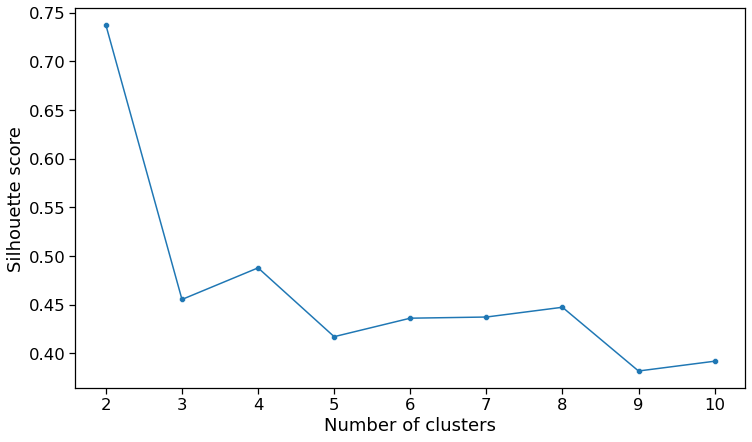

In [ ]:
# Plotting the Sillhoutte Score
plt.figure(figsize=(12,7))

sns.lineplot(number_of_cluster, silhouette_scores)
sns.scatterplot(number_of_cluster, silhouette_scores)

plt.xticks(number_of_cluster)

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(scaled_features)

KMeans(n_clusters=4)

In [ ]:
scaled_features['k_means_clust'] = kmeans.labels_
scaled_features


,recency,frequency,monetary,k_means_clust
0,-0.833414,-0.161046,-0.094902,3
1,-0.813826,-0.161046,-0.602808,3
2,1.948149,-0.161046,-0.341438,1
3,0.537779,-0.161046,-0.530060,1
4,0.322306,-0.161046,0.148580,1
...,...,...,...,...
95414,1.360495,-0.161046,8.430798,0
95415,0.152539,-0.161046,-0.348700,1
95416,2.150564,-0.161046,-0.225254,1
95417,-0.781178,-0.161046,-0.131254,3


In [ ]:
# Distributions Clusters
scaled_features['k_means_clust'].value_counts()

3    51806
1    38225
2     2882
0     2506
Name: k_means_clust, dtype: int64

In [ ]:
#assign customer segmentation based on overall score
segment_lst = scaled_features['k_means_clust']
segment_cluster = []

for i in segment_lst:
    if i == 3:
        cluster = 'passive'
        segment_cluster.append(cluster)
    elif i == 2:
        cluster = 'regular'
        segment_cluster.append(cluster)
    elif i == 1:
        cluster = 'valuable'
        segment_cluster.append(cluster)
    elif i == 0: 
        cluster = 'loyal'
        segment_cluster.append(cluster)

In [ ]:
scaled_features['k_means_segment'] = segment_cluster

In [ ]:
scaled_features

,recency,frequency,monetary,k_means_clust,k_means_segment
0,-0.833414,-0.161046,-0.094902,3,passive
1,-0.813826,-0.161046,-0.602808,3,passive
2,1.948149,-0.161046,-0.341438,1,valuable
3,0.537779,-0.161046,-0.530060,1,valuable
4,0.322306,-0.161046,0.148580,1,valuable
...,...,...,...,...,...
95414,1.360495,-0.161046,8.430798,0,loyal
95415,0.152539,-0.161046,-0.348700,1,valuable
95416,2.150564,-0.161046,-0.225254,1,valuable
95417,-0.781178,-0.161046,-0.131254,3,passive


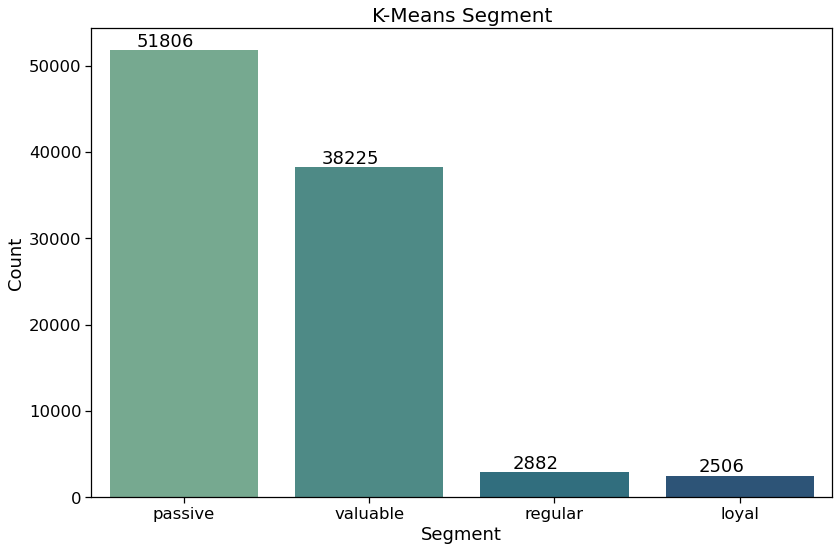

In [ ]:
plt.figure(figsize=(12, 8))
df_kmeans_cat = scaled_features['k_means_segment'].value_counts()
pal = sns.color_palette('crest', len(df_kmeans_cat))
graph =sns.barplot(x=df_kmeans_cat.index, y=df_kmeans_cat.values, palette=pal) 
for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')     
plt.title('K-Means Segment', size=20)
plt.ylabel('Count')
plt.xlabel('Segment')
plt.tight_layout()
plt.show()

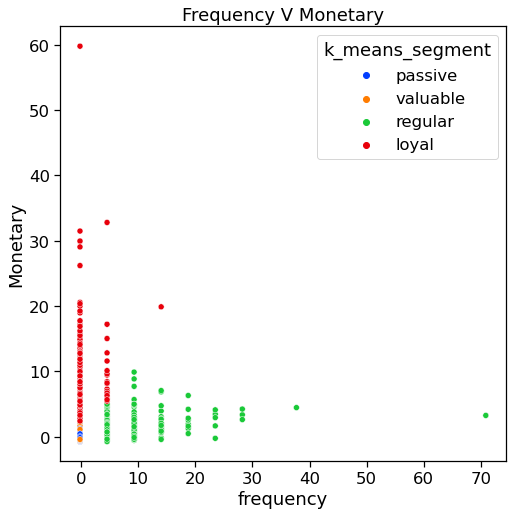

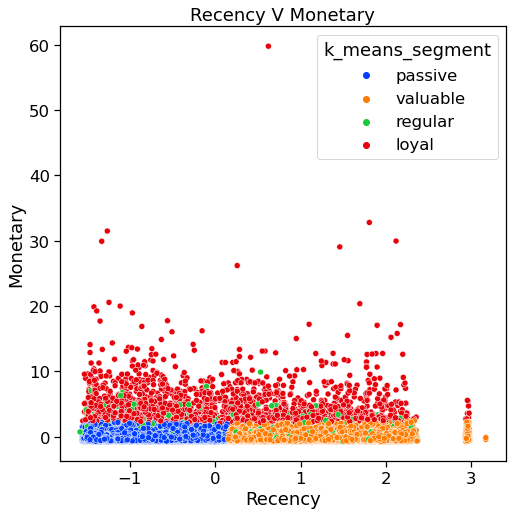

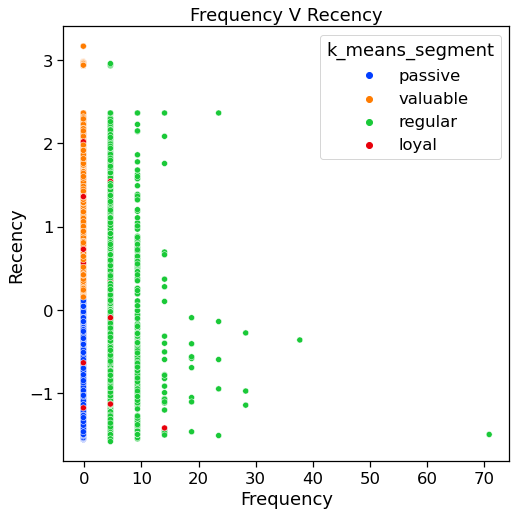

In [ ]:
# Frequency V Monetary
plt.figure(figsize = (8, 8) )
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'frequency', 
    y = 'monetary', 
    hue = 'k_means_segment',
    data = scaled_features,
    palette='bright')
plt.title('Frequency V Monetary')
plt.ylabel('Monetary')
plt.xlabel('frequency')
plt.show()

# Monetary V Recency
plt.figure(figsize = (8, 8) )
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'recency', 
    y = 'monetary', 
    hue = 'k_means_segment',
    data = scaled_features,
    palette='bright')
plt.title('Recency V Monetary')
plt.ylabel('Monetary')
plt.xlabel('Recency')
plt.show()

# Frequency V Recency
plt.figure(figsize = (8, 8) )
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'frequency', 
    y = 'recency', 
    hue = 'k_means_segment',
    data = scaled_features,
    palette='bright')
plt.title('Frequency V Recency')
plt.ylabel('Recency')
plt.xlabel('Frequency')
plt.show()

## Agglomerative Clustering

**Using agglometarive, we can get 3 clusters, there are dormant, typical, and golden. Dorman is when frequency, frequency, and monetary values are the lowest. Typical is when values of monetary and transaction is in the middle of all values. Golden is frequency, frequency, and monetary values are the highest.**

In [82]:
#for easier computation, using 10% of total data
sample = resample(scaled_features,n_samples=11843,random_state=13)

In [85]:
scaled_features.rename(columns={'clusters': 'k_means_clust', 'customer_segment' : 'k_means_segment'}, inplace = True)
aglo_X = sample[['recency' ,'frequency' ,'monetary']]

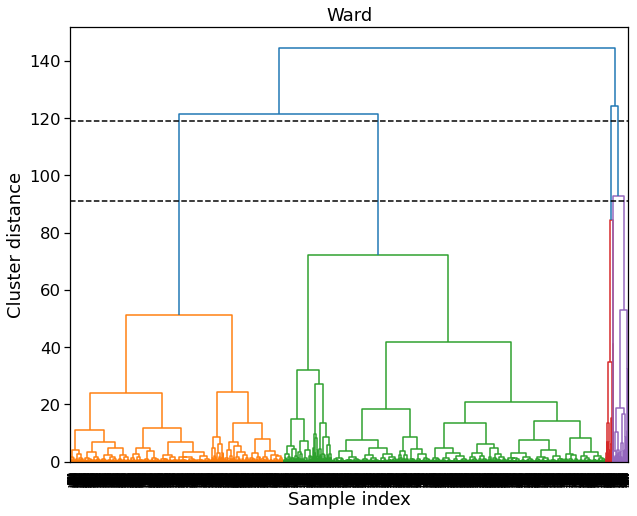

In [86]:
linkage_array = ward(aglo_X)

plt.figure(figsize = (10,8))

dendrogram(linkage_array, 25)
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [119, 119], '--', c='k')
ax.plot(bounds, [91, 91], '--', c='k')
plt.title('Ward')
plt.xlabel("Sample index")
plt.xticks(rotation = 90)
plt.ylabel("Cluster distance")

plt.show()

In [88]:
agg_average = AgglomerativeClustering(n_clusters=3, linkage = 'ward')
sample['aglo_clust'] = agg_average.fit_predict(aglo_X)

In [89]:
# Distributions Clusters
sample['aglo_clust'].value_counts()

0    11378
1      327
2      138
Name: aglo_clust, dtype: int64

In [90]:
#assign customer segmentation based on overall score
segment_lst = sample['aglo_clust']
segment_cluster = []

for i in segment_lst:
    if i == 0:
        cluster = 'dormant'
        segment_cluster.append(cluster)
    elif i == 1:
        cluster = 'typical' 
        segment_cluster.append(cluster)
    else:
        cluster = 'golden'
        segment_cluster.append(cluster)

In [91]:
sample['aglo_segment'] = segment_cluster

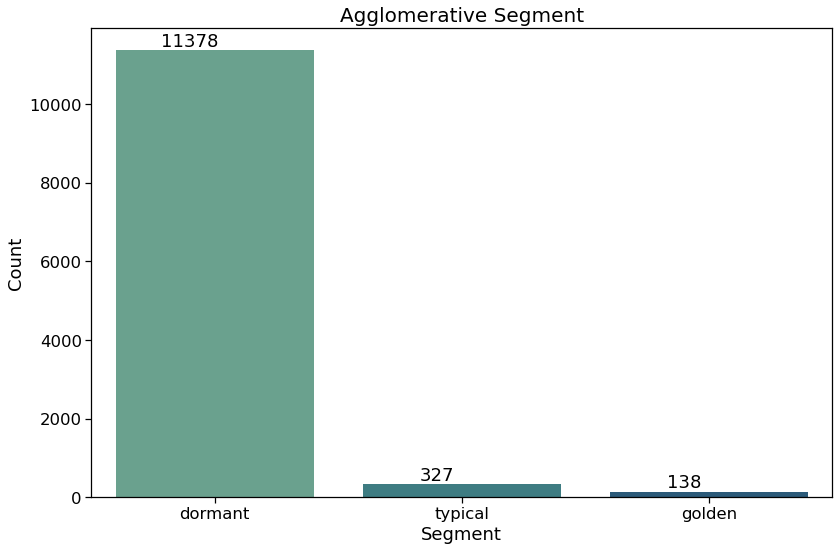

In [92]:
plt.figure(figsize=(12, 8))
df_algo_cat = sample['aglo_segment'].value_counts()
pal = sns.color_palette('crest', len(df_algo_cat))
graph =sns.barplot(x=df_algo_cat.index, y=df_algo_cat.values, palette=pal) 
for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')     
plt.title('Agglomerative Segment', size=20)
plt.ylabel('Count')
plt.xlabel('Segment')
plt.tight_layout()
plt.show()

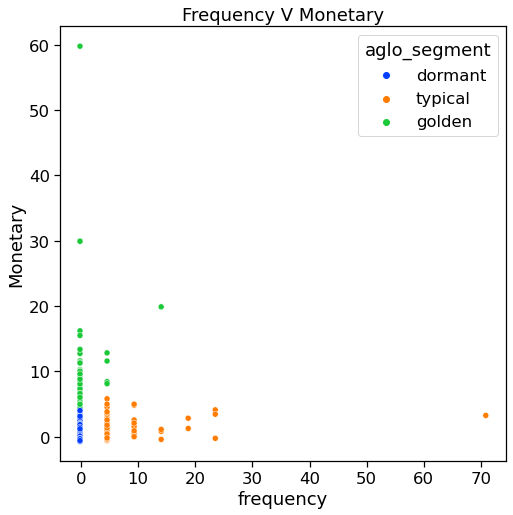

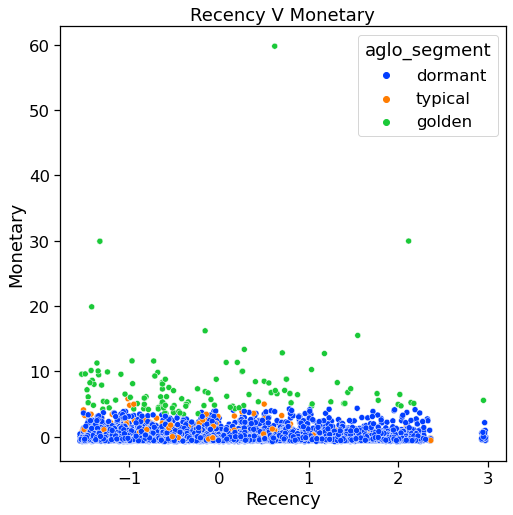

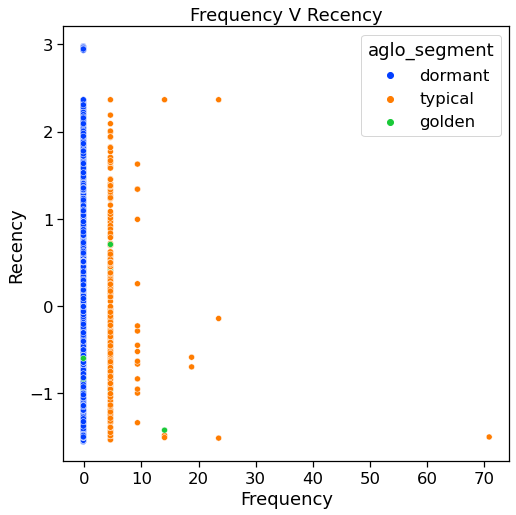

In [96]:
# Frequency V Monetary
plt.figure(figsize = (8, 8) )
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'frequency', 
    y = 'monetary', 
    hue = 'aglo_segment',
    data = sample,
    palette='bright')
plt.title('Frequency V Monetary')
plt.ylabel('Monetary')
plt.xlabel('frequency')
plt.show()

# Monetary V Recency
plt.figure(figsize = (8, 8) )
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'recency', 
    y = 'monetary', 
    hue = 'aglo_segment',
    data = sample,
    palette='bright')
plt.title('Recency V Monetary')
plt.ylabel('Monetary')
plt.xlabel('Recency')
plt.show()

# Frequency V Recency
plt.figure(figsize = (8, 8) )
sns.set_context(context = 'notebook', font_scale=1.5)
sns.scatterplot(
    x = 'frequency', 
    y = 'recency', 
    hue = 'aglo_segment',
    data = sample,
    palette='bright')
plt.title('Frequency V Recency')
plt.ylabel('Recency')
plt.xlabel('Frequency')
plt.show()

## + Pilih hasil dari rfm segmentasi atau kmeans atau agglomerative + alasan

## + kesimpulan dan saran berdasarkan bisnis . kesimpulan terkait pemodelan (misal kelebihan dan kekurangan dari hasil rfm segmentasi dan kmeans)
